In [1]:
from pykeops.torch import LazyTensor
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler

In [2]:
torch.manual_seed(0)

In [3]:
device = 'cuda:1'

In [4]:
def rand_nys_appx(K, n, r, device):
    # Calculate sketch
    Phi = torch.randn((n, r), device=device) / (n ** 0.5)
    Phi = torch.linalg.qr(Phi, mode='reduced')[0]

    Y = K @ Phi

    # Calculate shift
    shift = torch.finfo(Y.dtype).eps
    Y_shifted = Y + shift * Phi

    # Calculate Phi^T * K * Phi (w/ shift) for Cholesky
    choleskytarget = torch.mm(Phi.t(), Y_shifted)

    # Perform Cholesky decomposition
    C = torch.linalg.cholesky(choleskytarget)

    B = torch.linalg.solve_triangular(C.t(), Y_shifted, upper=True, left=False)
    U, S, _ = torch.linalg.svd(B, full_matrices=False)
    S = torch.max(torch.square(S) - shift, torch.tensor(0.0))

    return U, S

In [5]:
def loss(K, b, lambd, a):
    return 1/2 * torch.dot(a, K @ a) + lambd / 2 * torch.dot(a, a) \
            - torch.dot(b, a) 

In [6]:
def gd(K, b, lambd, a0, rho, eta, r, max_iter, device):
    n = K.shape[0]
    U, S = rand_nys_appx(K, n, r, device)
    
    a = a0.clone()
    for i in range(max_iter):
        g = K @ a + lambd * a - b
        UTg = U.t() @ g
        dir = U @ (UTg / (S + rho)) + 1/rho * (g - U @ UTg)
        a -= eta * dir

        print(f"iter {i}, loss {loss(K, b, lambd, a)}")

    return a

In [7]:
def get_blocks(n, B):
    # Permute the indices
    idx = torch.randperm(n)

    # Partition the indices into B blocks of roughly equal size
    # Do this by first computing the block size then making a list of block sizes
    block_size = n // B
    remainder = n % B
    sizes = [block_size] * B

    for i in range(remainder):
        sizes[i] += 1

    blocks = torch.split(idx, sizes)

    return blocks

In [8]:
def get_L(K, lambd, U, S, rho):
    n = U.shape[0]
    v = torch.randn(n, device=U.device)
    v = v / torch.linalg.norm(v)

    max_eig = None

    for _ in range(10): # TODO: Make this a parameter or check tolerance instead
        v_old = v.clone()

        UTv = U.t() @ v
        v = U @ (UTv / ((S + rho) ** (0.5))) + 1/(rho ** 0.5) * (v - U @ UTv)

        v = K @ v + lambd * v

        UTv = U.t() @ v
        v = U @ (UTv / ((S + rho) ** (0.5))) + 1/(rho ** 0.5) * (v - U @ UTv)

        max_eig = torch.dot(v_old, v)

        v = v / torch.linalg.norm(v)

    return max_eig

In [9]:
# For RBF kernel only -- need to generalize
def bcd(x, b, sigma, lambd, a0, B, r, max_iter, device, fig_name=''):
    x_i = LazyTensor(x[:, None, :])
    x_j = LazyTensor(x[None, :, :])
    D = ((x_i - x_j) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    n = K.shape[0]
    blocks = get_blocks(n, B)
    block_preconds = []
    block_rhos = []
    block_etas = []

    residual = -b # NOTE: this line assumes a0 = 0
    b_norm = torch.norm(b).cpu()
    rel_residuals = []

    # Compute randomized Nystrom approximation corresponding to each block
    for i, block in enumerate(blocks):
        xb_i = LazyTensor(x[block][:, None, :])
        xb_j = LazyTensor(x[block][None, :, :])
        Db = ((xb_i - xb_j) ** 2).sum(dim=2)
        Kb = (-Db / (2 * sigma ** 2)).exp()

        U, S = rand_nys_appx(Kb, block.shape[0], r, device)
        rho = lambd + S[-1]
        block_preconds.append((U, S))
        block_rhos.append(rho)
        block_etas.append(2 / get_L(Kb, lambd, U, S, rho))

    plt.figure()
    plt.hist([eta.cpu() for eta in block_etas], bins=100)
    plt.xlabel("Block learning rates")
    plt.ylabel("Frequency")
    plt.savefig(f"etas_{fig_name}.pdf")

    a = a0.clone()
    for i in range(max_iter):
        # Randomly select a block
        block_idx = torch.randint(B, (1,))

        # Get the block and its corresponding preconditioner
        block = blocks[block_idx]
        U, S = block_preconds[block_idx]
        rho = block_rhos[block_idx]
        eta = block_etas[block_idx]

        # Compute block gradient
        xb_i = LazyTensor(x[block][:, None, :])
        Dbn = ((xb_i - x_j) ** 2).sum(dim=2)
        Kbn = (-Dbn / (2 * sigma ** 2)).exp()

        gb = Kbn @ a + lambd * a[block] - b[block]

        # Apply preconditioner
        UTgb = U.t() @ gb
        dir = U @ (UTgb / (S + rho)) + 1/rho * (gb - U @ UTgb)

        # Update block
        a[block] -= eta * dir

        residual[block] += lambd * (-eta * dir)
        residual += Kbn.t() @ (-eta * dir)

        # print(f"iter {i}, loss {loss(K, b, lambd, a)}")
        # print(f"iter {i}, relative residual {torch.norm(residual) / b_norm}")
        print(f"iter {i}")
        rel_residuals.append(torch.norm(residual).cpu() / b_norm)

    plt.figure()
    plt.semilogy(rel_residuals)
    plt.xlabel("Iteration")
    plt.ylabel("Relative residual")
    plt.savefig(f"rel_residuals_{fig_name}.pdf")

    return a

In [10]:
# For RBF kernel only -- need to generalize
def acc_bcd(x, b, sigma, lambd, a0, B, r, max_iter, device, fig_name=''):
    x_i = LazyTensor(x[:, None, :])
    x_j = LazyTensor(x[None, :, :])
    D = ((x_i - x_j) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    n = K.shape[0]
    blocks = get_blocks(n, B)
    block_preconds = []
    block_rhos = []
    block_Ls = []
    block_etas = []

    b_norm = torch.norm(b).cpu()
    rel_residuals = []

    alpha = 1/2
    S_alpha = 0

    # Compute randomized Nystrom approximation corresponding to each block
    for i, block in enumerate(blocks):
        xb_i = LazyTensor(x[block][:, None, :])
        xb_j = LazyTensor(x[block][None, :, :])
        Db = ((xb_i - xb_j) ** 2).sum(dim=2)
        Kb = (-Db / (2 * sigma ** 2)).exp()

        U, S = rand_nys_appx(Kb, block.shape[0], r, device)
        rho = lambd + S[-1]
        block_preconds.append((U, S))
        block_rhos.append(rho)

        L = get_L(Kb, lambd, U, S, rho)
        S_alpha += L ** alpha
        block_Ls.append(L)
        block_etas.append(2 / L)

    block_probs = torch.tensor([L ** alpha / S_alpha for L in block_Ls])
    sampling_dist = torch.distributions.categorical.Categorical(block_probs)
    tau = 2 / (1 + (4 * (S_alpha ** 2) / lambd + 1) ** 0.5)
    gamma = 1 / (tau * S_alpha ** 2)

    plt.figure()
    plt.hist([eta.cpu() for eta in block_etas], bins=100)
    plt.xlabel("Block learning rates")
    plt.ylabel("Frequency")
    plt.savefig(f"etas_{fig_name}.pdf")

    a = a0.clone()
    y = a0.clone()
    z = a0.clone()

    # NOTE: This only works if a0 = 0
    Ka = 0
    Ky = 0
    Kz = 0

    for i in range(max_iter):
        # Randomly select a block
        block_idx = sampling_dist.sample()

        # Get the block and its corresponding preconditioner
        block = blocks[block_idx]
        U, S = block_preconds[block_idx]
        rho = block_rhos[block_idx]
        eta = block_etas[block_idx]

        # Compute block gradient
        xb_i = LazyTensor(x[block][:, None, :])
        Dbn = ((xb_i - x_j) ** 2).sum(dim=2)
        Kbn = (-Dbn / (2 * sigma ** 2)).exp()

        gb = Kbn @ a + lambd * a[block] - b[block]

        # Apply preconditioner
        UTgb = U.t() @ gb
        dir = U @ (UTgb / (S + rho)) + 1/rho * (gb - U @ UTgb)

        # Update y
        y = a.clone()
        y[block] -= eta * dir
        Kdir = Kbn.t() @ dir
        Ky = Ka - eta * Kdir

        # Update z
        # z[block] = (1 / (1 + gamma * lambd)) * (z[block] + gamma * lambd * a[block] - gamma / block_probs[block_idx] * dir)
        z = (1 / (1 + gamma * lambd)) * (z + gamma * lambd * a)
        z[block] -= (1 / (1 + gamma * lambd)) * gamma / block_probs[block_idx] * dir
        Kz = (1 / (1 + gamma * lambd)) * (Kz + gamma * lambd * Ka - gamma / block_probs[block_idx] * Kdir)

        # Update x
        a = tau * z + (1 - tau) * y
        Ka = tau * Kz + (1 - tau) * Ky

        # Update residual
        residual = Ky + lambd * y - b

        # print(f"iter {i}, loss {loss(K, b, lambd, a)}")
        print(f"iter {i}, relative residual {torch.norm(residual) / b_norm}")
        print(f"iter {i}")
        rel_residuals.append(torch.norm(residual).cpu() / b_norm)

    plt.figure()
    plt.semilogy(rel_residuals)
    plt.xlabel("Iteration")
    plt.ylabel("Relative residual")
    plt.savefig(f"rel_residuals_{fig_name}.pdf")

    return y

In [11]:
data = load_svmlight_file('./data/SUSY')

In [12]:
b = data[1]
# b[b == 0] = -1

x_tr = data[0][:4500000].toarray()
b_tr = b[:4500000]

x_tst = data[0][4500000:].toarray()
b_tst = b[4500000:]

scaler = StandardScaler()
scaler.fit_transform(x_tr)
x_tr = scaler.transform(x_tr)
x_tst = scaler.transform(x_tst)

N_x = x_tr.shape[0]

x_tr = torch.from_numpy(x_tr).float().to(device)
x_tr.requires_grad = True
b_tr = torch.from_numpy(b_tr).float().to(device)

x_i = LazyTensor(x_tr[:, None, :])
x_j = LazyTensor(x_tr[None, :, :])

sigma = 4.0
D_ij = ((x_i - x_j) ** 2).sum(dim=2)  # Squared Euclidean distances
K_ij = (- D_ij / (2 * sigma ** 2)).exp()  # Gaussian kernel matrix, still lazy

In [13]:
# # Example sizes
# N_x = 10000000  # Number of rows in x

# # Generate random data
# x = torch.randn(N_x, 3, dtype=torch.float32, requires_grad=True).to(device)

# # Define your LazyTensors
# x_i = LazyTensor(x[:, None, :])  # Shape (N_x, 1, 3)
# x_j = LazyTensor(x[None, :, :])  # Shape (1, N_y, 3)

# # Compute the Gaussian kernel matrix
# sigma = 1.0  # Kernel width
# D_ij = ((x_i - x_j) ** 2).sum(dim=2)  # Squared Euclidean distances
# K_ij = (- D_ij / (2 * sigma ** 2)).exp()  # Gaussian kernel matrix, still lazy

In [14]:
# b = torch.randn(N_x, dtype=torch.float32).to(device)
a0 = torch.zeros(N_x, dtype=torch.float32).to(device)
lambd = 4.5 # (10 ** -2) / N_x
B = 450
r = 30
max_iter = 100

In [15]:
# Ground truth
# a_star = K_ij.solve(torch.unsqueeze(b, 1), alpha=lambd)
# print(loss(K_ij, b, lambd, torch.squeeze(a_star)))

In [16]:
# with torch.no_grad():
#     a = gd(K_ij, b, lambd, a0, rho, eta, r, max_iter, device)

In [17]:
# with torch.no_grad():
#     a = bcd(x_tr, b_tr, sigma, lambd, a0, B, r, max_iter, device, fig_name='lr_mult_by_2')

[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : 

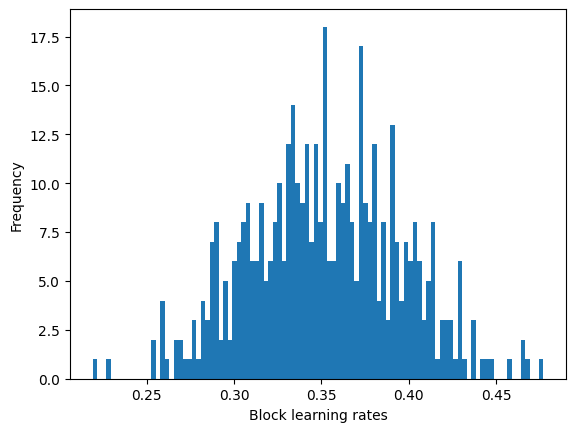

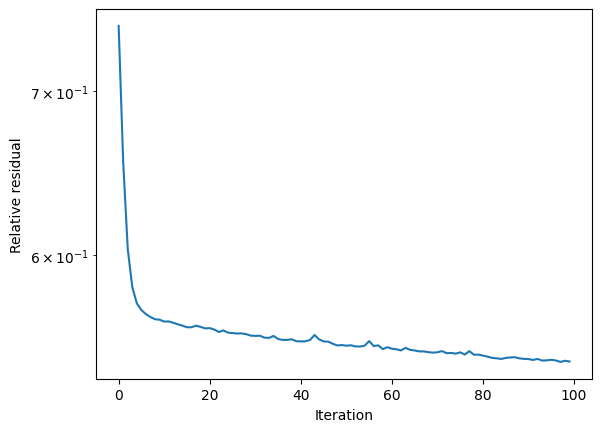

In [18]:
with torch.no_grad():
    a = acc_bcd(x_tr, b_tr, sigma, lambd, a0, B, r,
                max_iter, device, fig_name='acc_test')

In [19]:
# print(loss(K_ij, b_tr, lambd, a))